# OCR Agent from scratch:

* [Data](./Data-Sources.ipynb)
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* Generate training data
    * [Labeling](./Data-Extraction-3.ipynb)
    * [Pipeline](./Data-Extraction-Pipeline.ipynb)
    * Datasets
* [Model architecture](./Model-Backbone.ipynb)
* [Traversal strategies](./Traversal-Layout.ipynb)
* [Reader Agent](./Agent-LM.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)


### Datasets for training
We've got some labeled data, let's construct some `torch.utils.data.Dataset` for training with `PyTorch`.

In [1]:
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import patches

In [2]:
from scripts.dataset import *

In [3]:
labels = pd.read_csv('./data/training-labels.csv')
index = pd.read_csv('./data/training-index.csv')
trainset = index[index['test']==0]['source'].tolist()
testset  = index[index['test']==1]['source'].tolist()
len(trainset), len(testset)

(7679, 837)

In [4]:
INDEX  = labels[(labels['label'].str.len()==1)&(labels['count'] > 1)]['label'].tolist()
WEIGHT = labels.set_index('label').loc[INDEX,'weight'].tolist()
len(INDEX), len(WEIGHT)

(139, 139)

In [5]:
NUM_CLASSES = 156

EXTRAS = [s for s in '‹›«»"|_' if s not in INDEX]
INDEX = [' '] + INDEX + EXTRAS
WEIGHT = [round(1./len(trainset + testset), 4)] + WEIGHT + [1.] * len(EXTRAS)
INDEX += [''] * (NUM_CLASSES - len(INDEX))
WEIGHT += [1e-6] * (NUM_CLASSES - len(WEIGHT))

In [6]:
len(INDEX), len(WEIGHT)

(156, 156)

<a name="vanilla"></a>

### Dataset for `vanilla` VAE training

In [7]:
class VanillaDataset(TokenDataset):
    def __init__(self, source, labels, amp=1, min_count=1, dim=32, rec_dim=22, transform=0.9, empty=True):
        super().__init__(source, labels, amp=amp, min_count=min_count, dim=dim)
        self.rec = (rec_dim, rec_dim)
        self.transform_threshold = transform
        self.empty = empty
        
    def transform(self, clip, sigma):
        if np.random.rand() > self.transform_threshold:
            return clip
        h, w = clip.shape
        box = np.array([[1, 1],[h - 1, 1],[h - 1, w - 1],[1, w - 1]])
        skew = box + np.random.normal(0, sigma, (4, 2))
        matrix = cv2.getPerspectiveTransform(box.astype(np.float32), skew.astype(np.float32))
        return cv2.warpPerspective(clip, matrix, (h, w),flags=cv2.INTER_LINEAR)
    
    def __getitem__(self, idx):
        if self.empty and np.random.rand() < 1./len(self.index):
            # blank space
            return torch.zeros(self.dim).unsqueeze(0), torch.zeros(self.rec), 0
        box, label, neighbors = self.get_values(idx)
        x, y, w, h = box
        view = self.transform(self.clip(x, y, w, h), h//10)
        X = torch.Tensor(cv2.resize(view, self.dim, cv2.INTER_AREA)).unsqueeze(0)
        Y = torch.Tensor(cv2.resize(view, self.rec, cv2.INTER_AREA))
        return X, Y, self.encode(label)
    

0 N   u 7 2 C B S V R c ( % q  


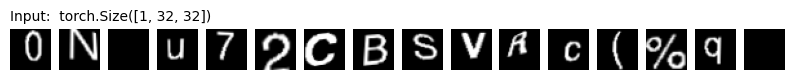

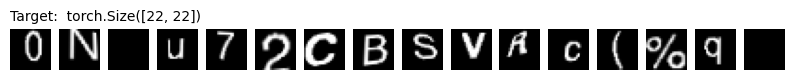

(torch.Size([16, 1, 32, 32]), torch.Size([16, 22, 22]), torch.Size([16]))

In [8]:
source = np.random.choice(testset)

for X, Y, L in DataLoader(VanillaDataset(source, INDEX, transform=0.95), batch_size=16, shuffle=True):
    print(' '.join([INDEX[x] for x in L.numpy().flatten()]))
    show_inputs(X)
    show_targets(Y)
    break
X.shape, Y.shape, L.shape

<a name="concept"></a>

### Dataset for `concept`-model training

In [9]:
class ConceptDataset(VanillaDataset):
    def __getitem__(self, idx):
        box, label, neighbors = self.get_values(idx)
        x, y, w, h = box
        concept = self.clip(x, y, w, h)
        view = self.transform(concept, h//10)
        X = torch.Tensor(cv2.resize(view, self.dim, cv2.INTER_AREA)).unsqueeze(0)
        Y = torch.Tensor(cv2.resize(concept, self.rec, cv2.INTER_AREA))
        return X, Y, self.encode(label)
    

. D p A s S ( B b , 0 ) Y h y c


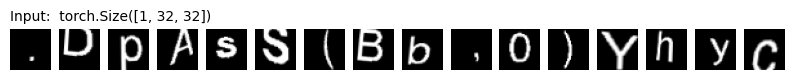

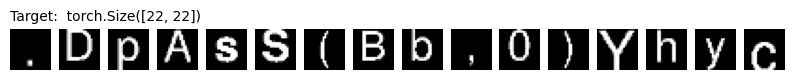

(torch.Size([16, 1, 32, 32]), torch.Size([16, 22, 22]), torch.Size([16]))

In [10]:
source = np.random.choice(testset)

for X, Y, L in DataLoader(ConceptDataset(source, INDEX, transform=0.95), batch_size=16, shuffle=True):
    print(' '.join([INDEX[x] for x in L.numpy().flatten()]))
    show_inputs(X)
    show_targets(Y)
    break
X.shape, Y.shape, L.shape

<a name="focus"></a>

### Dataset for `focus`-model training

In [11]:
class FocusDataset(TokenDataset):
    def __init__(self, source, labels, rec_dim=22, transform=0.9, empty=True, **kwargs):
        super().__init__(source, labels, **kwargs)
        self.rec = (rec_dim, rec_dim)
        self.transform_threshold = transform
        self.empty = empty
        
    def transform(self, views, sigma, margins=[0, 0]):
        if np.random.rand() > self.transform_threshold:
            return views
        h, w = views[0].shape
        output = []
        skew = np.random.normal(0, sigma, (4, 2))
        for view, m in zip(views, margins):
            box = np.array([[m, m],[h - m, m],[h - m, w - m],[m, w - m]])
            matrix = cv2.getPerspectiveTransform(box.astype(np.float32), (box + skew).astype(np.float32))
            output.append(cv2.warpPerspective(view, matrix, (h, w),flags=cv2.INTER_LINEAR))
        return output
    
    def __getitem__(self, idx):
        if self.empty and np.random.rand() < 1./len(self.index):
            # blank space
            return torch.zeros(self.dim).unsqueeze(0), torch.zeros(self.rec), 0
        box, label, neighbors = self.get_values(idx)
        x, y, w, h = box
        target = self.clip(x - 1, y - 2, w + 2, h + 4)
        d = h//4
        s = max(w + d * 2, h + d)
        dx, dy = (s - w)//2, (s - h)//2
        context = self.clip(x - dx, y - dy, s, s)
        target, context = self.transform((target, context), 4)
        X = torch.Tensor(cv2.resize(context, self.dim, cv2.INTER_AREA)).unsqueeze(0)
        Y = torch.Tensor(cv2.resize(target, self.rec, cv2.INTER_AREA))
        return X, Y, self.encode(label)
    

3 j B 8 5 6 p T I   r 1 E u d y


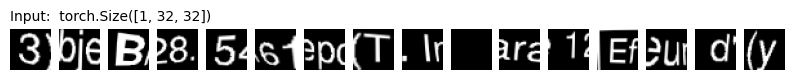

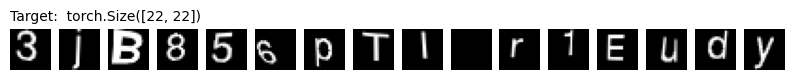

(torch.Size([16, 1, 32, 32]), torch.Size([16, 22, 22]), torch.Size([16]))

In [12]:
source = np.random.choice(testset)

for X, Y, L in DataLoader(FocusDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    print(' '.join([INDEX[x] for x in L.numpy().flatten()]))
    show_inputs(X)
    show_targets(Y)
    break
X.shape, Y.shape, L.shape

<a name="context"></a>

### Dataset for `context`-model training

In [13]:
class ContextDataset(FocusDataset):    
    def classify(self, neighbors):
        left, right = neighbors
        if left != ' ' and right != ' ':
            return 0 # mid-word
        if left == ' ' and right != ' ':
            return 1 # head
        if left != ' ' and right == ' ':
            return 2 # tail
        return 3 # stand-alone
    
    def get_raw(self, idx):
        if self.empty and np.random.rand() < 1./len(self.index):
            # blank space
            return np.zeros(self.dim), np.zeros(self.rec), 0, 4
        box, label, neighbors = self.get_values(idx)
        x, y, w, h = box
        d = 2 * h//3
        s = max(w + d * 2, h + d)
        dx, dy = (s - w)//2, (s - h)//2
        view = self.clip(x - dx, y - dy, s, s)
        context = view.copy()
        t, b, l, r = (s - h)//2 - 1, (s + h)//2 + 2, (s - w)//2 - 1, (s + w)//2 + 2
        context[t:b,l:r] = 0
        state = self.classify(neighbors)
        return view, context, self.encode(label), state    
    
    def __getitem__(self, idx):
        view, context, label, state = self.get_raw(idx)
        view = cv2.resize(view, self.dim, cv2.INTER_AREA)
        context = cv2.resize(context, self.rec, cv2.INTER_AREA)
        X = torch.Tensor(cv2.resize(view, self.dim, cv2.INTER_AREA)).unsqueeze(0)
        Y = torch.Tensor(cv2.resize(context, self.rec, cv2.INTER_AREA))
        return view, context, label, state
    

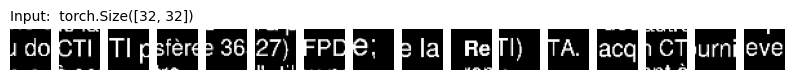

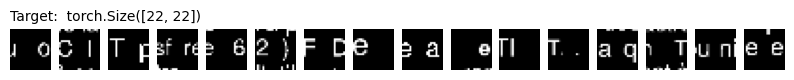

tensor([1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 0])
torch.Size([16, 32, 32]) torch.Size([16, 22, 22])


In [14]:
source = np.random.choice(testset)

for X, Y, L, S in DataLoader(ContextDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    show_inputs(X)
    show_targets(Y)
    print(S)
    break
print(X.shape, Y.shape)

    # estimate class weight
    cls = []
    for source in trainset:
        for X, Y, L, S in DataLoader(ContextDataset(source, INDEX), batch_size=16):
            cls += list(S.numpy())

    count = pd.DataFrame(Counter(cls).most_common(), columns=('class','weight')).set_index('class')
    weight = count.min().iloc[0]/count
    weight = weight.sort_index()
    weight.loc[:,'weight'] = weight['weight'].round(4)
    weight['name'] = ['mid','head','tail','single','empty']    
    weight.to_csv('data/context-weight.csv')

In [15]:
pd.read_csv('data/context-weight.csv').set_index('class')

,weight,name
class,,
0,0.0429,mid
1,0.0488,head
2,0.0988,tail
3,0.2304,single
4,1.0000,empty


In [16]:
EMPTY = 4

<a name="pre"></a>

### Dataset for pretraining

In [17]:
class PretrainingDataset(ContextDataset):
    options = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]
    
    def spoil(self, view):
        partial = view.copy()
        if np.random.rand() < 0.3:
            return partial
        s = view.shape[0]
        d = np.random.randint(s//8, s//2)
        a = np.random.randint(0, s - d)
        options = [(slice(None, None), slice(a, a + d)),(slice(a, a + d), slice(None, None))]
        o = np.random.choice(len(options))
        r, c = options[o]
        partial[r,c] *= np.random.normal(0, 1, size=(s, d) if o == 0 else (d, s))
        return np.clip(partial, 0, 1)
    
    def __getitem__(self, idx):
        # get view, context and labels
        V, C, label, state = super().get_raw(idx)
        if state == EMPTY:
            X, Y = [self.spoil(V + np.random.rand(*V.shape) * 0.001) for _ in range(3)], [C] * 3
            if np.random.rand() > 0.5:
                X = [1. - x for x in X]
            return [torch.Tensor(x).unsqueeze(0) for x in X], [torch.Tensor(y) for y in Y] #, [0, 0]
        
        box, _, neighbors = self.get_values(idx)
        x, y, w, h = box
        X, Y = [], []
        # char
        orig = self.clip(x - 1, y - 2, w + 2, h + 4)
        view = self.transform((orig,), h//10)[0]
        X.append(cv2.resize(self.spoil(view), self.dim, cv2.INTER_AREA))
        Y.append(cv2.resize(view, self.rec, cv2.INTER_AREA))
        # focus
        d = h//4
        s = max(w + d * 2, h + d)
        dx, dy = (s - w)//2, (s - h)//2
        orig = self.clip(x - dx, y - dy, s, s)
        view = self.transform((orig,), 4)[0]
        X.append(cv2.resize(self.spoil(view), self.dim, cv2.INTER_AREA))
        Y.append(cv2.resize(view, self.rec, cv2.INTER_AREA))
        # context
        X.append(cv2.resize(self.spoil(V), self.dim, cv2.INTER_AREA))
        Y.append(cv2.resize(V, self.rec, cv2.INTER_AREA))
        # rotation
        orientation = np.random.choice(len(self.options))
        if orientation != 0:
            angle = self.options[orientation]
            X = [cv2.rotate(x, angle) for x in X]
            Y = [torch.Tensor(cv2.rotate(y, angle)) for y in Y]
        X, Y = [torch.Tensor(x).unsqueeze(0) for x in X], [torch.Tensor(y) for y in Y]
        if np.random.rand() > 0.5:
            return [1. - x for x in X], Y #, [label, orientation]
        return X, Y #, [label, orientation]
 

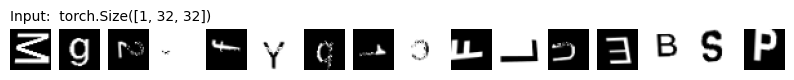

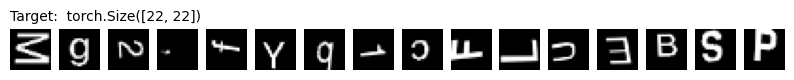

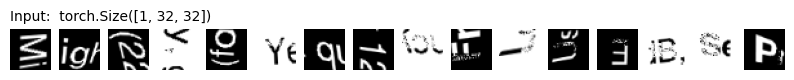

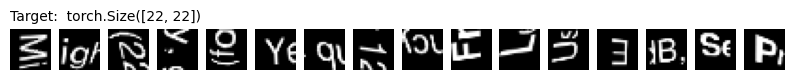

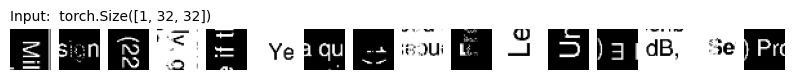

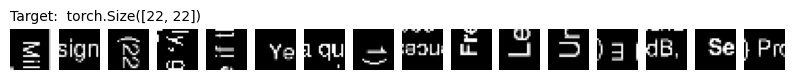

In [18]:
source = np.random.choice(testset)

for X, Y in DataLoader(PretrainingDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    for i in range(len(X)):
        show_inputs(X[i])
        show_targets(Y[i])
    break

<a name="multi"></a>

### Dataset for multi-task training

In [19]:
class MultitaskDataset(ContextDataset):
    def spoil(self, view):
        partial = view.copy()
        if np.random.rand() < 0.3:
            return partial
        s = view.shape[0]
        d = np.random.randint(s//8, s//2)
        a = np.random.randint(0, s - d)
        options = [(slice(None, None), slice(a, a + d)),(slice(a, a + d), slice(None, None))]
        o = np.random.choice(len(options))
        r, c = options[o]
        partial[r,c] *= np.random.normal(0, 1, size=(s, d) if o == 0 else (d, s))
        return np.clip(partial, 0, 1)
    
    def __getitem__(self, idx):
        # get view, context and labels
        V, C, label, semantic = super().get_raw(idx)
        if semantic == EMPTY:
            X, Y = [self.spoil(V + np.random.rand(*V.shape) * 1e-4) for _ in range(3)], [C] * 3
            if np.random.rand() > 0.5:
                X = [1. - x for x in X]
            return [torch.Tensor(x).unsqueeze(0) for x in X], [torch.Tensor(y) for y in Y], [0, EMPTY, 0, 0]
        
        box, _, neighbors = self.get_values(idx)
        x, y, w, h = box
        X, Y = [], []
        # concept
        concept = self.clip(x - 1, y - 2, w + 2, h + 4)
        view = self.transform((concept,), h//10)[0]
        X.append(cv2.resize(self.spoil(view), self.dim, cv2.INTER_AREA))
        Y.append(cv2.resize(concept, self.rec, cv2.INTER_AREA))
        # focus
        d = h//4
        s = max(w + d * 2, h + d)
        dx, dy = (s - w)//2, (s - h)//2
        view = self.clip(x - dx, y - dy, s, s)
        focus, view = self.transform((concept, view), 4)
        X.append(cv2.resize(self.spoil(view), self.dim, cv2.INTER_AREA))
        Y.append(cv2.resize(focus, self.rec, cv2.INTER_AREA))
        # context
        left, right = [self.encode(x) for x in neighbors]
        X.append(cv2.resize(self.spoil(V), self.dim, cv2.INTER_AREA))
        Y.append(cv2.resize(C, self.rec, cv2.INTER_AREA))
        X, Y = [torch.Tensor(x).unsqueeze(0) for x in X], [torch.Tensor(y) for y in Y]
        if np.random.rand() > 0.5:
            return [1. - x for x in X], Y, [label, semantic, left, right]
        return X, Y, [label, semantic, left, right]
    

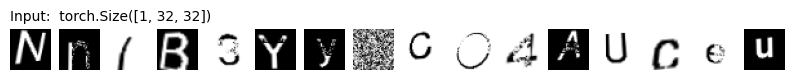

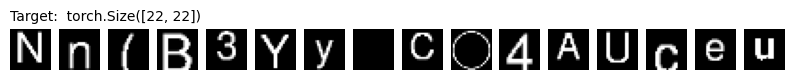

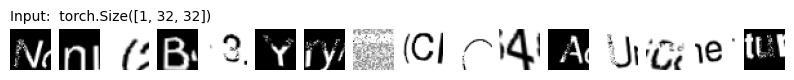

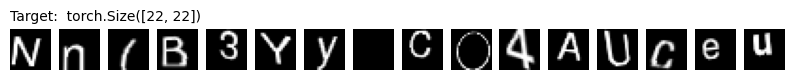

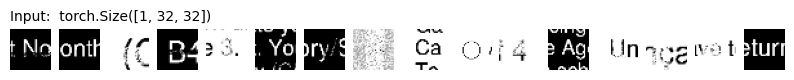

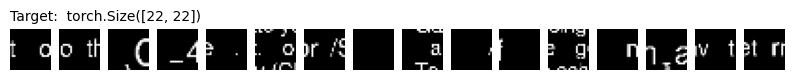

tensor([1, 0, 1, 1, 1, 1, 0, 4, 1, 2, 3, 1, 1, 0, 2, 0])


In [20]:
source = np.random.choice(testset)

for X, Y, L in DataLoader(MultitaskDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    for i in range(len(X)):
        show_inputs(X[i])
        show_targets(Y[i])
    break
print(L[1])